In [75]:
### Setting the environment
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
import requests
from textwrap import wrap

In [68]:
### Loading data

### From ckan output
source_ckan = pd.read_csv('../data/ckan_output.csv')
source_ckan['Source'] = 'ckan API'

### From google sheets
source_gsheets = pd.read_csv('../data/from_Google_Sheets.csv')
source_gsheets['Source'] = 'manual extraction'

### From arcgis api
source_arcgis = pd.DataFrame()
folder = '../data/arcgis/'
for dirname, _, filenames in os.walk(folder):
    for filename in filenames:
        if filename.rsplit('.',1)[1] == 'csv':
            source_arcgis = source_arcgis.append(pd.read_csv(folder + r'/' + filename))
source_arcgis['Source'] = 'arcgis API'

### From usmart api
source_usmart = pd.DataFrame()
folder = '../data/USMART/'
for dirname, _, filenames in os.walk(folder):
    for filename in filenames:
        if filename.rsplit('.',1)[1] == 'csv':
            source_usmart = source_usmart.append(pd.read_csv(folder + r'/' + filename))
source_usmart['Source'] = 'USMART API'

### Combine all data into single table
data = source_ckan.append([source_gsheets, source_arcgis, source_usmart])
data = data.reset_index(drop=True)

### Some cleaning
### Remove these irrelevant entries (not councils)
drop_list = ['Development, Safety and Regulation']
data = data[~data['Owner'].isin(drop_list)]
### Renaming entries to match
owner_renames = {
                'Aberdeen': 'Aberdeen City',
                'Dundee': 'Dundee City',
                'Perth': 'Perth and Kinross',
                'open.data@southayrshire':'South Ayrshire'
                }
data['Owner'] = data['Owner'].replace(owner_renames)
### Format dates as datetime type
data['DateUpdated'] = pd.to_datetime(data['DateUpdated'], format='%Y-%m-%d', errors='coerce')

### Output combined data to csv
data.to_csv('../data/merged_output.csv')

### Additional cleaning
### Removed 'Council' from all labels for brevity in visual displays.
data['Owner'] = data['Owner'].str.replace(' Council','')

### New dataset: Distinct datasets by council
data_distinct = data[['Owner','Title','PageURL','Source']]
data_distinct = data_distinct.drop_duplicates()

### Loading list of local authorities (from wikidata)
data_localauthorities = pd.read_csv('../data/local_authorities_list.csv').rename(columns={'itemLabel':'Council'})
data_localauthorities['Council'] = data_localauthorities['Council'].str.replace(' Council','')

### Quality check: These owners in dataset cannot be matched to the appropriate council names
owners = pd.DataFrame(set(data['Owner'])).rename(columns={0:'Owner'})
owners = owners.merge(data_localauthorities, how='left', left_on='Owner', right_on='Council')
qc_owners = owners[owners['Council'].isna()]
if len(qc_owners) > 0:
    print('Quality check: These owners in dataset cannot be matched to the appropriate council names')
    qc_owners
else: None


In [105]:
### default settings for plt graphs
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### function to add data labels
def addlabels(x,y,dp):
    for i in range(len(x)):
        plt.text(i, y[i], round(y[i],dp), ha = 'center')

### function to wrap axis labels
def wrapaxis(col,text_wrap):
    xlabels = [ '\n'.join(wrap(l, text_wrap)) for l in col]
    plt.xticks(range(0,len(col)),labels=xlabels)

### make standard column chart
def columnchart(title, x_col, y_col, ):
    plt.figure(figsize=(15,3))
    fig = plt.bar(x=x_col, height=y_col)
    plt.ylabel(''), plt.xlabel(''), plt.yticks([])
    addlabels(x_col, y_col,0)
    wrapaxis(x_col,10)
    plt.title(title)
    plt.savefig(title+'.png')
    plt.show()

In [52]:
print('Generated: ', dt.datetime.now().strftime('%d-%b-%Y %H:%M'))

Generated:  22-Jun-2021 23:39


## Dataset Overview
An overview of the OD files available and which councils provide them

In [69]:
print('all data files: ', len(data))
print('distinct datasets: ', len(data_distinct))

all data files:  953
distinct datasets:  427


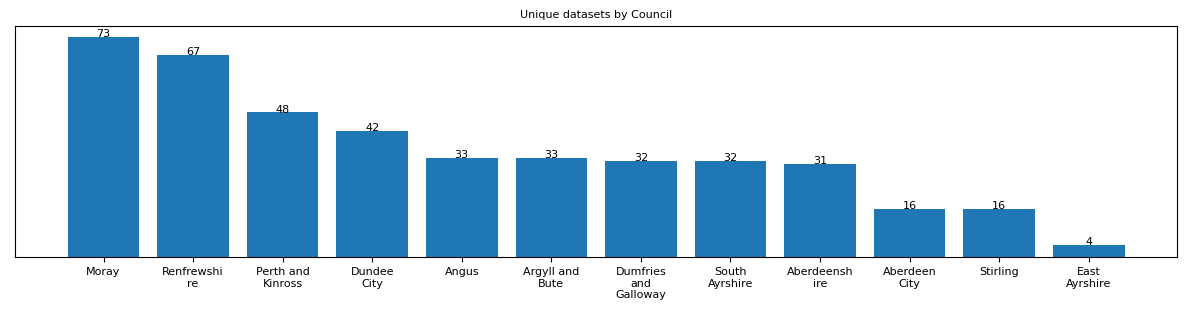

In [106]:
### Unique datasets by council
stats_a = data_distinct.groupby(['Owner']).size().reset_index().rename(columns={0:'Count'})
stats_a = stats_a.sort_values(by=['Count'], ascending=False).reset_index(drop=True)

### Chart
columnchart('Unique datasets by Council', stats_a['Owner'], stats_a['Count'])


## Dataset Sources
Looking at how these OD files are accessed via API or our manual extraction

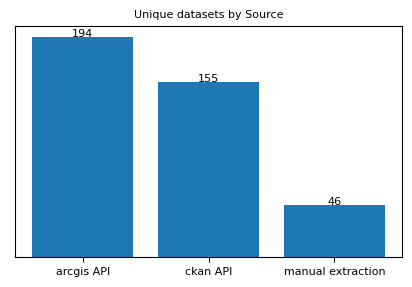

In [54]:
### Unique datasets by Source
stats_b1 = data_distinct.groupby(['Source']).size().reset_index().rename(columns={0:'Count'})
stats_b1 = stats_b1.sort_values(by=['Count'], ascending=False).reset_index(drop=True)

### Chart
plt.figure(figsize=(5,3))
plt.bar(x=stats_b1['Source'], height=stats_b1['Count'])
plt.ylabel(''), plt.xlabel(''), plt.yticks([])
addlabels(stats_b1['Source'], stats_b1['Count'],0)
plt.title('Unique datasets by Source')
plt.savefig('Unique datasets by Source.png')
plt.show()


In [6]:
### Unique datasets by Council and Source
stats_b = data_distinct.groupby(['Owner','Source']).size().reset_index().rename(columns={0:'Count'})
stats_b = stats_b.sort_values(by=['Count'], ascending=False)

### Unique datasets by Council and Source, as matrix
stats_b_pivot = stats_b.pivot(index='Owner',columns='Source', values='Count').reset_index()
stats_b_pivot.loc['Source_Total']= stats_b_pivot.sum(numeric_only=True, axis=0)
stats_b_pivot.loc[:,'Council_Total'] = stats_b_pivot.sum(numeric_only=True, axis=1)
stats_b_pivot

Source,Owner,arcgis API,ckan API,manual extraction,Council_Total
0,Aberdeen City,NaN,16.0,NaN,16.0
1,Aberdeenshire,NaN,NaN,31.0,31.0
2,Angus,NaN,33.0,NaN,33.0
3,Argyll and Bute,33.0,NaN,NaN,33.0
4,Dundee City,NaN,42.0,NaN,42.0
5,East Ayrshire,NaN,NaN,4.0,4.0
6,Moray,62.0,NaN,11.0,73.0
7,Perth and Kinross,NaN,48.0,NaN,48.0
8,Renfrewshire,67.0,NaN,NaN,67.0
9,South Ayrshire,32.0,NaN,NaN,32.0


## Filetypes
There are 24 different filetypes labelled in our dataset but the distribution is very uneven. The clear popular format is the open CSV format, but we also see some proprietary spreadsheet formats such as XLSX and the now depreciated XLS format. 

Bear in mind that several of these files will be duplicated, but in different formats. For example, KMZ is the compressed format of KML. ZIP files may contain several different formats together.


In [34]:
### Table showing counts by filetypes
pd.DataFrame(\
        data.groupby(['FileType']).size())\
    .rename(columns={0:'Count'})\
    .sort_values(by='Count', ascending=False)\
    .reset_index()
    

,FileType,Count
0,CSV,279
1,Feature Layer,158
2,GeoJSON,75
3,KML,67
4,HTML,52
5,ZIP,40
6,WMS,30
7,Esri REST,30
8,KMZ,28
9,XLSX,23


We also see inconsistency in filetype metadata. 

There are filetypes labelled "Table", "Image", and "Document Link" which are descriptions rather than names of file formats. All of these come from 1 API and council, and is suggestive of a lack of standardised labelling.

Only 10 of the 24 formats (~40%) are provided by more than 1 council, which again suggests inconsistencies, but this time it could be that the actual filetypes provided are unusual, or it could be labelling errors as before. 

In [35]:
### Table showing number of councils providing each filetypes
data.groupby(['FileType'])['Owner'].nunique()\
    .reset_index()\
    .sort_values(by='Owner', ascending=False)\
    .rename(columns={'Owner':'Count of Councils Providing'})\
    .reset_index(drop=True)

,FileType,Count of Councils Providing
0,CSV,8
1,GeoJSON,5
2,ZIP,4
3,Feature Layer,4
4,HTML,4
5,PDF,4
6,KML,4
7,XLSX,3
8,WMS,2
9,Esri REST,2


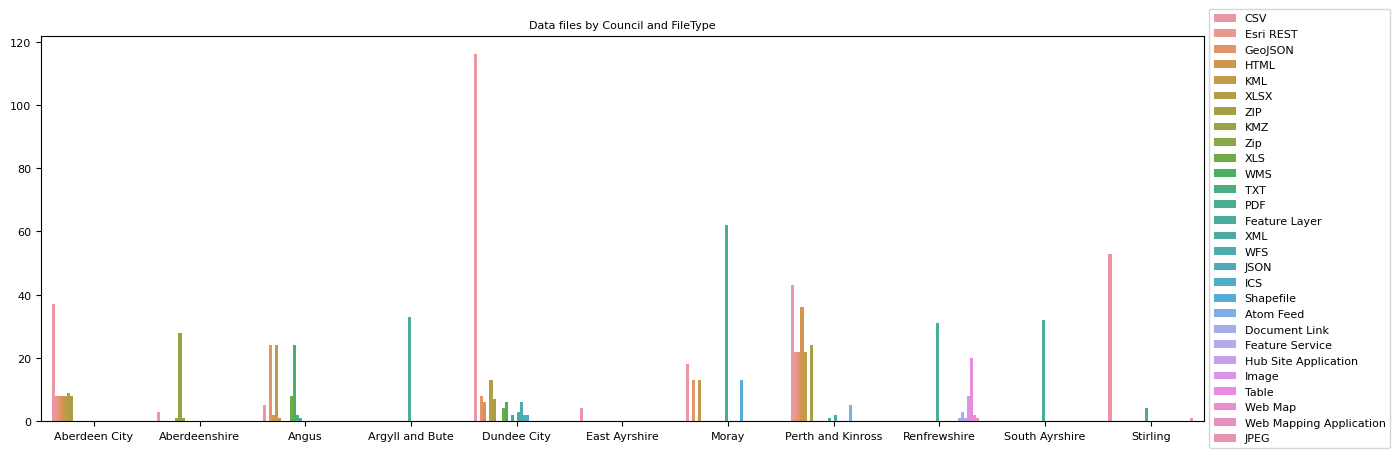

In [36]:
### Count of data files by Council and FileType, ordered by Council name
stats_c = data.groupby(['Owner','FileType']).size().reset_index().rename(columns={0:'Count'})
stats_c = stats_c.sort_values(by=['Owner'], ascending=True).reset_index(drop=True)

### Chart
plt.figure(figsize=(15,5))
sns.barplot(x='Owner', y='Count', data=stats_c, hue='FileType')
plt.ylabel(''), plt.xlabel('')
plt.title('Data files by Council and FileType')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Data files by Council and FileType.png')
plt.show()


In [37]:
### Count of data files by Council and FileType, as matrix (rows=filetype, columns=council), ordered by FileType count

stats_c_pivot = stats_c.pivot(index='FileType',columns='Owner', values='Count')
stats_c_pivot.loc[:,'FileType_Total'] = stats_c_pivot.sum(numeric_only=True, axis=1)
stats_c_pivot = stats_c_pivot.sort_values(by='FileType_Total', ascending=False)
stats_c_pivot.loc['Council_Total']= stats_c_pivot.sum(numeric_only=True, axis=0)
stats_c_pivot





Owner,Aberdeen City,Aberdeenshire,Angus,Argyll and Bute,Dundee City,East Ayrshire,Moray,Perth and Kinross,Renfrewshire,South Ayrshire,Stirling,FileType_Total
FileType,,,,,,,,,,,,
CSV,37.0,3.0,5.0,NaN,116.0,4.0,18.0,43.0,NaN,NaN,53.0,279.0
Feature Layer,NaN,NaN,NaN,33.0,NaN,NaN,62.0,NaN,31.0,32.0,NaN,158.0
GeoJSON,8.0,NaN,24.0,NaN,8.0,NaN,13.0,22.0,NaN,NaN,NaN,75.0
KML,8.0,NaN,24.0,NaN,NaN,NaN,13.0,22.0,NaN,NaN,NaN,67.0
HTML,8.0,NaN,2.0,NaN,6.0,NaN,NaN,36.0,NaN,NaN,NaN,52.0
ZIP,8.0,1.0,NaN,NaN,7.0,NaN,NaN,24.0,NaN,NaN,NaN,40.0
WMS,NaN,NaN,24.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,30.0
Esri REST,8.0,NaN,NaN,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,30.0
KMZ,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0


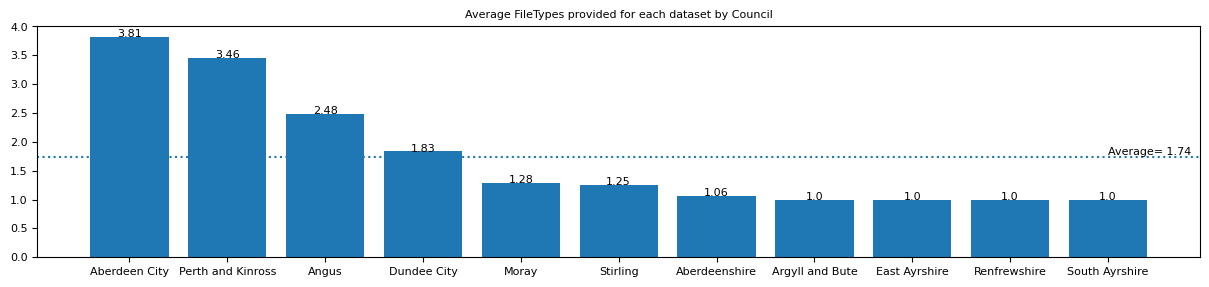

In [56]:
### Average count of filetypes provided per dataset, by council
stats_e = data.groupby(['Owner','Title'])['FileType'].nunique().reset_index()
stats_e = stats_e.groupby(['Owner'])['FileType'].mean().reset_index()
stats_e = stats_e.sort_values(by=['FileType'], ascending=False).reset_index(drop=True)
stats_e_mean = round(stats_e['FileType'].mean(),2)

### Chart
plt.figure(figsize=(15,3))
plt.bar(x=stats_e['Owner'], height=stats_e['FileType'])
plt.ylabel(''), plt.xlabel('')
addlabels(stats_e['Owner'], stats_e['FileType'],2)
plt.axhline(y=stats_e_mean, linestyle=':')
plt.text(x=len(stats_e)-1, y=stats_e_mean, s='Average= '+ str(stats_e_mean), verticalalignment='bottom')
plt.title('Average FileTypes provided for each dataset by Council')
plt.savefig('Average FileTypes provided for each dataset by Council.png')
plt.show()

Bottom line: There is a wide range of filetypes available, but this range is likely due to inconsistencies in labelling rather than a true variety of filetype offerings. The most popular filetype is CSV, which is offered by the most councils and also makes the largest share of all offerings.

## File size

In [13]:
### Convert file size units to bytes
def filesize_convert(unit, val):
    byte_conversions = {
            'bytes': 1,
            'B': 1,
            'KB': 1000,
            'MB': 1000000,
            'GB': 1000000000
        }
    if (unit in list(byte_conversions.keys())) & (val > 0):
        conv_bytes = val * byte_conversions[unit]
    else: 
        conv_bytes = None
        
    return conv_bytes

### apply conversion function
data['FileSizeBytes'] = data.apply(lambda x: filesize_convert(x['FileSizeUnit'], x['FileSize']), axis=1)
data['FileSizeBins'] = pd.cut(x=data['FileSizeBytes'], bins=[1,1000,10000,100000,1000000,10000000, 100000000, 1000000000, 10000000000], labels=['<1KB','1-10KB','10-100KB','0.1-1MB','1-10MB','10-100MB','0.1-1GB','1-10GB'])

### Quality check: instances with no filesize info
filesize_issues = len(data[data['FileSizeBytes'].isnull()])
if filesize_issues > 0:
    print('There is no filesize info for ',filesize_issues,' files.')
else: None

There is no filesize info for  106  files.


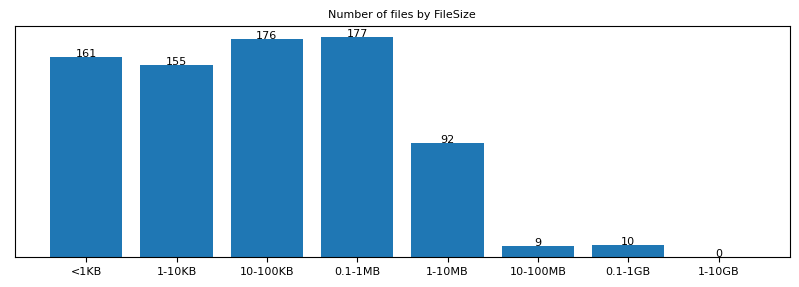

In [57]:
### Count of files by filesize bins
stats_g = data.groupby(['FileSizeBins']).size().reset_index()

### Chart
plt.figure(figsize=(10,3))
plt.bar(x=stats_g['FileSizeBins'], height=stats_g[0])
addlabels(stats_g['FileSizeBins'], stats_g[0],0)
plt.ylabel(''), plt.xlabel(''), plt.yticks([])
plt.title('Number of files by FileSize')
plt.show()


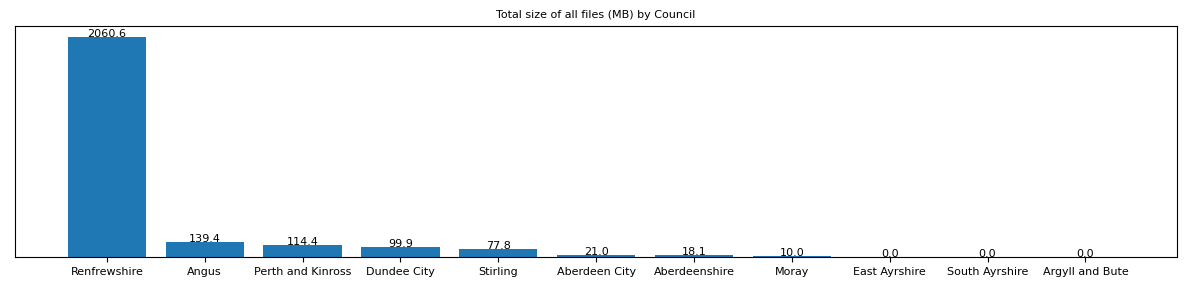

In [58]:
### Filesize totals by council
stats_g1 = data.groupby(['Owner'])['FileSizeBytes'].sum().reset_index()
stats_g1['FileSizeMB'] = stats_g1['FileSizeBytes']/1000000
stats_g1 = stats_g1.sort_values(by=['FileSizeMB'], ascending=False).reset_index(drop=True)

### Chart
plt.figure(figsize=(15,3))
plt.bar(x=stats_g1['Owner'], height=stats_g1['FileSizeMB'])
addlabels(stats_g1['Owner'], stats_g1['FileSizeMB'],1)
plt.title('Total size of all files (MB) by Council')
plt.ylabel(''), plt.xlabel(''), plt.yticks([])
plt.show()

#stats_g1

## Dataset Tags

In [16]:
### New dataset: Tags used in the datasets
data_tags = data[['Owner', 'PageURL','OriginalTags','ManualTags']]
data_tags = data_tags.drop_duplicates()
### combine the Original and Manual tags together then split them out
data_tags['AllTags'] = data_tags.apply(lambda x: str(x['OriginalTags'])+ ';' + str(x['ManualTags']), axis=1)
data_tags['AllTags'] = data_tags['AllTags'].str.replace(',',';')
data_tags = data_tags.join(data_tags['AllTags'].str.split(';', expand = True))
### unpivot the table from wide to long format
data_tags = data_tags.drop(columns=['OriginalTags','ManualTags','AllTags'])
data_tags = data_tags.melt(id_vars=['Owner','PageURL'])
### Clean up: remove nones
data_tags = data_tags.drop(data_tags[data_tags['value']=='nan'].index)
data_tags = data_tags.dropna()
### Clean up: remove redundant column and rename the other
data_tags = data_tags.drop(columns=['variable'])
data_tags = data_tags.rename(columns={'value':'Tag'})
### Clean up: set all tags to lowercase and trim
data_tags['Tag'] = data_tags['Tag'].str.lower()
data_tags['Tag'] = data_tags['Tag'].str.strip()

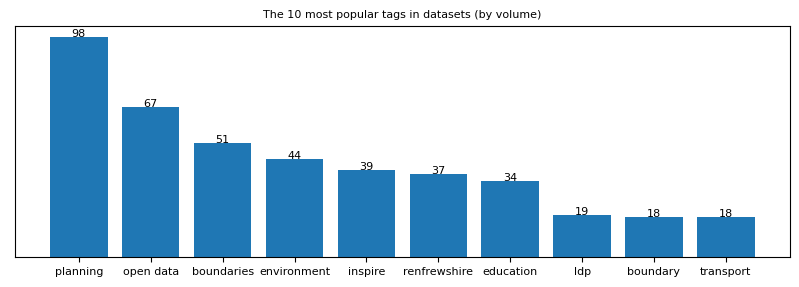

In [59]:
### The 10 most popular tags
stats_d = pd.DataFrame(data_tags['Tag'].value_counts()).head(10)

plt.figure(figsize=(10,3))
plt.bar(x=stats_d.index, height=stats_d['Tag'])
plt.ylabel(''), plt.xlabel(''), plt.yticks([])
addlabels(stats_d.index, stats_d['Tag'],0)
plt.title('The 10 most popular tags in datasets (by volume)')
plt.show()


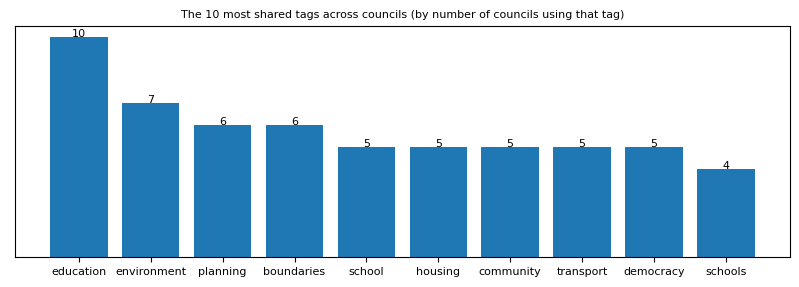

In [62]:
### The 10 most shared tags across councils
stats_d1 = pd.DataFrame(data_tags.groupby(['Tag'])['Owner'].nunique()).sort_values(by=['Owner'],ascending=False).head(10)

plt.figure(figsize=(10,3))
plt.bar(x=stats_d1.index, height=stats_d1['Owner'])
plt.ylabel(''), plt.xlabel(''), plt.yticks([])
addlabels(stats_d1.index, stats_d1['Owner'],0)
plt.title('The 10 most shared tags across councils (by number of councils using that tag)')
plt.show()


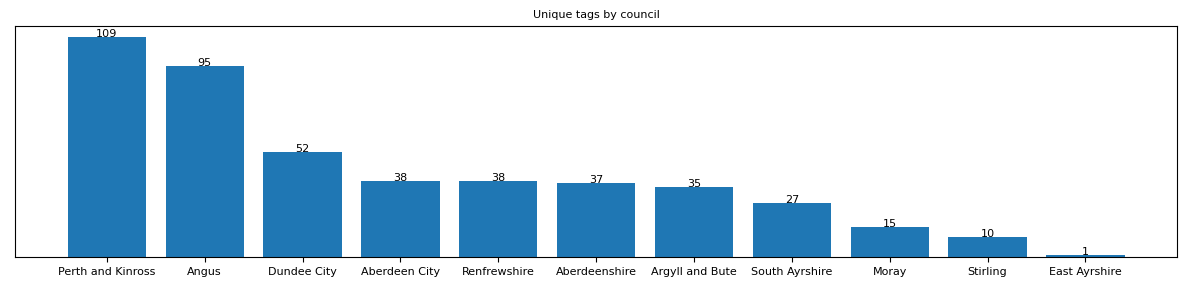

In [61]:
### Number of unique tags by council
stats_d2 = pd.DataFrame(data_tags.groupby(['Owner'])['Tag'].nunique()).sort_values(by=['Tag'],ascending=False)

plt.figure(figsize=(15,3))
plt.bar(x=stats_d2.index, height=stats_d2['Tag'])
plt.ylabel(''), plt.xlabel(''), plt.yticks([])
addlabels(stats_d2.index, stats_d2['Tag'],0)
plt.title('Unique tags by council')
plt.show()


In [20]:
### Matrix of tags used by council
stats_d3 = pd.DataFrame(\
                    data_tags.groupby(['Tag','Owner']).size())\
                .reset_index()\
                .pivot(index='Tag',columns='Owner',values=0)
stats_d3.loc[:,'Tag_Total'] = stats_d3.sum(numeric_only=True, axis=1)
stats_d3.loc['Council_Total',:] = stats_d3.sum(numeric_only=True, axis=0)

### Export to 'output_TagsByCouncil.csv'
stats_d3.to_csv('output_TagsByCouncil.csv')

### Show a snippet for "elec"
elec_tag_list = [t for t in stats_d3.index.values if t[0:4]=='elec']
stats_d3.loc[elec_tag_list,:]

Owner,Aberdeen City,Aberdeenshire,Angus,Argyll and Bute,Dundee City,East Ayrshire,Moray,Perth and Kinross,Renfrewshire,South Ayrshire,Stirling,Tag_Total
Tag,,,,,,,,,,,,
elecorate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
election,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
elections,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,5.0
electoral,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
electorate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
electric vehicle,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0


## Dataset Licensing

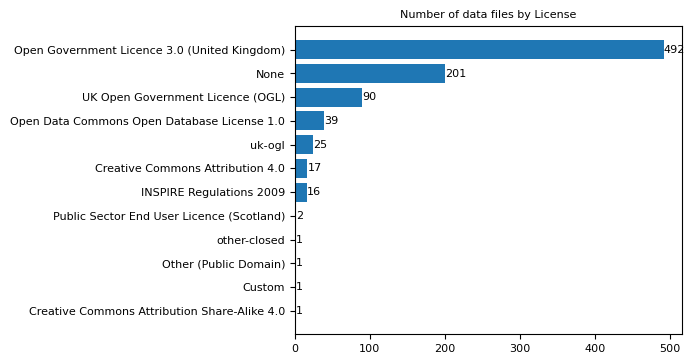

In [21]:
stats_h = pd.DataFrame(data.groupby(['License'], dropna=False).size().sort_values(ascending=True)).reset_index().rename(columns={0:'Count'})
stats_h = stats_h.fillna('None')

plt.figure(figsize=(5,4))
plt.barh(y=stats_h['License'], width=stats_h['Count'])
plt.ylabel(''), plt.xlabel('')
for i in range(len(stats_h['License'])):
    y=stats_h['Count']
    plt.text(y[i], i, round(y[i],0), va = 'center')
plt.title('Number of data files by License')
plt.show()

In [22]:
pd.DataFrame(data.groupby(['Source','License'], dropna=False).size()).reset_index().rename(columns={0:'Count'}).fillna('None')

,Source,License,Count
0,arcgis API,None,194
1,ckan API,Creative Commons Attribution 4.0,17
2,ckan API,Creative Commons Attribution Share-Alike 4.0,1
3,ckan API,Open Data Commons Open Database License 1.0,39
4,ckan API,Open Government Licence 3.0 (United Kingdom),419
5,ckan API,Other (Public Domain),1
6,ckan API,Public Sector End User Licence (Scotland),2
7,ckan API,UK Open Government Licence (OGL),90
8,ckan API,other-closed,1
9,ckan API,uk-ogl,25



## Check URL statuses

In [23]:
### shows progress indicator for slow processes.
def progress_indicator(n,jump,**kwargs):
### n is the current instance, jump is the instance increment to highlight, as is jump2 (e.g. show every 10 and 100). jump2 is optional.
    jump2 = kwargs.get('jump2', None)

    ### if the remainder of n/jump2 = 0 (i.e. a whole number)
    if (n>0) & (n%jump2 == 0):
        ### print the quotient + string marker
        print(str(n//jump2)+'00', end='', flush=True)
    ### otherwise print a * for every jump
    elif n%jump == 0:
        print('*', end='', flush=True)
    return

### get web status for assetURL
def check_status(url):
    try:
        response = requests.get(url)
        status = (response.status_code == 200)
    except:
        status = 'Error'
    return status

In [42]:
### This is a very very very slow process. It can take >10 minutes to check 800 urls. 
### I recommend skipping this if you're doing a light update.
### But if you want to get updated statuses (and wait for a while), type "IMSURE" when prompted.
### There is a progress indicator and confirmation at end.
are_you_sure = input("Update URL statuses: This is a very slow process, be prepared to wait over 10mins. To go ahead type IMSURE")

data['AssetStatus'] = None
if are_you_sure == 'IMSURE':
    for row in data.index:
        data.loc[row,'AssetStatus'] = check_status(data.loc[row,'AssetURL'])
        progress_indicator(row,10,jump2=100)
    
    print('\nok done. Last updated',dt.datetime.now().strftime(format='%d-%m-%Y %Hh:%Mm'))
    print(data['AssetStatus'].value_counts())

else:
    print('url status check skipped.')

url status check skipped.


## URL statuses by Council
This shows if the URL of OD assets are active (True) or not (False).
If it is True, the data is accessible, if it is False there is a hosting issue.
(Error) indicates there is no URL to check or it is missing from our data.

A full listing of the URL status is available in 'output_AllAnalytics.csv'

In [25]:
pd.DataFrame(data.groupby(['Owner','AssetStatus']).size()).reset_index().pivot(index='Owner',columns='AssetStatus',values=0)

AssetStatus,False,True,Error
Owner,,,
Aberdeen City,NaN,92.0,NaN
Aberdeenshire,NaN,33.0,NaN
Angus,24.0,66.0,1.0
Argyll and Bute,NaN,NaN,33.0
Dundee City,4.0,174.0,NaN
East Ayrshire,NaN,4.0,NaN
Moray,NaN,57.0,62.0
Perth and Kinross,10.0,168.0,1.0
Renfrewshire,NaN,NaN,67.0


## Summary Matrix

In [26]:
data.to_csv('output_AllAnalytics.csv')

In [27]:
summary_matrix = pd.DataFrame(data.groupby(['Owner'])['AssetURL'].size()).reset_index()
summary_matrix = summary_matrix.merge(data[data['AssetStatus']==True].groupby(['Owner'])['AssetStatus'].size().reset_index(), how='left', on='Owner')
summary_matrix['% Active URLs'] = summary_matrix['AssetStatus']/summary_matrix['AssetURL']
summary_matrix = summary_matrix.merge(stats_a, how='left', on='Owner')
summary_matrix = summary_matrix.merge(data.groupby(['Owner'])['Source'].nunique().reset_index(), how='left', on='Owner')
summary_matrix = summary_matrix.merge(data.groupby(['Owner'])['DateUpdated'].max().reset_index(), how='left', on='Owner')
summary_matrix = summary_matrix.merge(data.groupby(['Owner'])['License'].nunique().reset_index(), how='left', on='Owner')
summary_matrix = summary_matrix.merge(data_tags.groupby(['Owner'])['Tag'].nunique().reset_index(), how='left', on='Owner')
summary_matrix = summary_matrix.merge(data.groupby(['Owner'])['FileType'].nunique().reset_index(), how='left', on='Owner')
summary_matrix = summary_matrix.merge(stats_e, how='left', on='Owner')
summary_matrix = summary_matrix.merge(stats_g1[['Owner','FileSizeMB']], how='left', on='Owner')
summary_matrix['FileType_y'] = round(summary_matrix['FileType_y'],2)
summary_matrix['FileSizeMB'] = round(summary_matrix['FileSizeMB'],2)
column_rename = {'Owner':'Council',
                 'AssetURL':'#Files',
                 'AssetStatus':'Active URLs',
                 'Count':'#Datasets',
                 'Source':'#Data Sources',
                 'DateUpdated':'Last Updated',
                 'License':'#Licenses',
                 'Tag':'#Tags',
                 'FileType_x':'#FileTypes',
                 'FileType_y':'Avg FileTypes per Dataset',
                 'FileSizeMB':'Total Size (MB)'}
summary_matrix = summary_matrix.rename(columns=column_rename)

                                               
summary_matrix

,Council,#Files,Active URLs,% Active URLs,#Datasets,#Data Sources,Last Updated,#Licenses,#Tags,#FileTypes,Avg FileTypes per Dataset,Total Size (MB)
0,Aberdeen City,92,92.0,1.000000,16,1,2020-08-03,1,38,7,3.81,21.05
1,Aberdeenshire,33,33.0,1.000000,31,1,NaT,2,37,4,1.06,18.10
2,Angus,91,66.0,0.725275,33,1,2021-06-10,2,95,9,2.48,139.35
3,Argyll and Bute,33,NaN,NaN,33,1,2021-06-08,0,35,1,1.00,0.00
4,Dundee City,178,174.0,0.977528,42,1,2019-01-29,6,52,12,1.83,99.86
5,East Ayrshire,4,4.0,1.000000,4,1,NaT,1,1,1,1.00,0.01
6,Moray,119,57.0,0.478992,73,2,2021-06-12,2,15,5,1.28,9.99
7,Perth and Kinross,179,168.0,0.938547,48,1,2019-09-10,4,109,9,3.46,114.41
8,Renfrewshire,67,NaN,NaN,67,1,2021-04-30,0,38,8,1.00,2060.58
9,South Ayrshire,32,NaN,NaN,32,1,2021-03-24,0,27,1,1.00,0.00


# Scorecard

- Has an open data portal or site/ has OD content on the site
- Unique datasets
- Uses API
- Data has been published within the last 1 year, 6 months, 90 days or 30 days
- rank of # filetypes offered
- rank of combined data size
- average file size
- rank of unique tags used
- rank of % active URLS

In [28]:
# Calculating Last updated

def days_updated(df):
    last_update = df[['Council','Last Updated']].copy()
    last_update['Days_Passed'] = last_update['Last Updated'].apply(lambda x: (dt.datetime.today() - x).days)
    last_update['Last 365 days'] = last_update['Days_Passed'] < 365
    last_update['Last 180 days'] = last_update['Days_Passed'] < 180
    last_update['Last 90 days'] = last_update['Days_Passed'] < 90
    last_update['Last 30 days'] = last_update['Days_Passed'] < 30
    last_update = last_update.drop(columns=['Last Updated','Days_Passed'])

    return last_update

In [29]:
### Putting the scorecard together

scorecard = data_localauthorities.copy()
### Has OD site
scorecard['Has OD Site'] = scorecard['Council'].isin(set(summary_matrix['Council']))
### Unique datasets
scorecard = scorecard.merge(summary_matrix[['Council','#Datasets']], how='left', on='Council')
scorecard['#Datasets'] = round(scorecard['#Datasets'].rank()/len(summary_matrix),2)
### % Active URLS
scorecard = scorecard.merge(summary_matrix[['Council','% Active URLs']], how='left', on='Council')
scorecard['% Active URLs'] = round(scorecard['% Active URLs'].rank()/len(summary_matrix),2)
### Last updates in 365, 180, 90, 30 days
scorecard = scorecard.merge(days_updated(summary_matrix), how='left', on='Council')
### Filetypes per dataset
scorecard = scorecard.merge(summary_matrix[['Council','Avg FileTypes per Dataset']], how='left', on='Council')
scorecard['Avg FileTypes per Dataset'] = round(scorecard['Avg FileTypes per Dataset'].rank()/len(summary_matrix),2)
### Total filesize
scorecard = scorecard.merge(summary_matrix[['Council','Total Size (MB)']], how='left', on='Council')
scorecard['Total Size (MB)'] = round(scorecard['Total Size (MB)'].rank()/len(summary_matrix),2)
### Unique tags used
scorecard = scorecard.merge(summary_matrix[['Council','#Tags']], how='left', on='Council')
scorecard['#Tags'] = round(scorecard['#Tags'].rank()/len(summary_matrix),2)

### Cleanup
scorecard = scorecard.fillna(0)
scorecard = scorecard.replace([True,False], [1,0])
scorecard.loc[:,'Council_Score'] = scorecard.sum(numeric_only=True, axis=1)
scorecard.sort_values(by='Council_Score', ascending=False).set_index('Council')

,Has OD Site,#Datasets,% Active URLs,Last 365 days,Last 180 days,Last 90 days,Last 30 days,Avg FileTypes per Dataset,Total Size (MB),#Tags,Council_Score
Council,,,,,,,,,,,
Angus,1,0.59,0.18,1,1,1,1,0.82,0.91,0.91,8.41
Moray,1,1.00,0.09,1,1,1,1,0.64,0.36,0.27,7.36
Renfrewshire,1,0.91,0.00,1,1,1,0,0.23,1.00,0.68,6.82
Argyll and Bute,1,0.59,0.00,1,1,1,1,0.23,0.14,0.45,6.41
Stirling,1,0.23,0.59,1,1,1,0,0.55,0.64,0.18,6.19
South Ayrshire,1,0.45,0.00,1,1,1,0,0.23,0.14,0.36,5.18
Aberdeen City,1,0.23,0.59,1,0,0,0,1.00,0.55,0.68,5.05
Perth and Kinross,1,0.82,0.27,0,0,0,0,0.91,0.82,1.00,4.82
Dundee City,1,0.73,0.36,0,0,0,0,0.73,0.73,0.82,4.37
